In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os
import glob, traceback
import seaborn as sns
import matplotlib.dates as mdates

## 0. Read all csv files

In [4]:
df_2019.head(1)

id                      created_at  \
0  1083147454290247680  Wed Jan 09 23:44:11 +0000 2019   

                             text              user_id name    screen_name  \
0  USER forever get chill HTTPURL  1008830740308680704    '  caprogers1940   

                                         description  DrugAbuse lang gender  \
0  -This is the fight of our lives-  @holdmyshiel...          1   en   male   

    age      org        date  is_teenage drug_type  sent_score sentiment race  
0  <=18  non-org  2020-01-01           1        []         0.0       neu  api

In [2]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2019 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2019.shape

df.shape, df_r.shape, df_2019.shape

((2799726, 17), (1811516, 18), (2799726, 18))

In [3]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2020 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2020.shape

df.shape, df_r.shape, df_2020.shape

((3502171, 17), (2275943, 18), (3502171, 18))

In [4]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_r.shape, df_2021.shape

((2553235, 17), (1723470, 18), (2553235, 18))

In [5]:
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [6]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [7]:
drug_cols = list(drug_keywords_map.keys())

In [8]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [9]:
# df_2019['drug_type'].value_counts(), df_2020['drug_type'].value_counts(), df_2021['drug_type'].value_counts()

# 1. Statistical Distribution by demographics

In [10]:
def get_the_agg_results(data, agg_by_user=False, race=False):
    years = [2019, 2020, 2021]
    age_groups = ['<=18','19-29', '30-39', '>=40']
    race_groups = ['api', 'white', 'hispanic', 'black']
    metrics = ['Total Tweets', 'Org', 'Person', 'Female', 'Male', 
           'Teenage', 'Adult', 'Teenage Female', 'Teenage Male', 'Adult Female', 'Adult Male'] + age_groups + ['Neutral', 'Positive', 'Negative']
    if race:
        metrics += race_groups 
    
    results = {metric: [] for metric in metrics}
    for i in range(3):
        dff = data[i]
        year = years[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        is_org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        total_tweets = dff.shape[0]
        count_is_org = is_org.shape[0]
        count_non_org = non_org.shape[0]
        percent_is_org = (count_is_org / total_tweets) * 100
        percent_non_org = (count_non_org / total_tweets) * 100

        total_user_tweets = count_non_org
        total_female_tweets = non_org[non_org['gender'] == 'female'].shape[0]
        total_male_tweets = non_org[non_org['gender'] == 'male'].shape[0]
        percent_female = (total_female_tweets / total_user_tweets) * 100
        percent_male = (total_male_tweets / total_user_tweets) * 100

        total_teenagers_tweets = non_org[non_org['is_teenage'] == 1].shape[0]
        total_adult_tweets = non_org[non_org['is_teenage'] != 1].shape[0]
        percent_teenage = (total_teenagers_tweets / total_user_tweets) * 100
        percent_adult = (total_adult_tweets / total_user_tweets) * 100

        tf = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'female')].shape[0]
        tm = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'male')].shape[0]
        af = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'female')].shape[0]
        am = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'male')].shape[0]
        percent_tf = (tf / total_user_tweets) * 100
        percent_tm = (tm / total_user_tweets) * 100
        percent_af = (af / total_user_tweets) * 100
        percent_am = (am / total_user_tweets) * 100

        total_neu_tweets = dff[(dff['sentiment'] == 'neu')].shape[0]
        total_pos_tweets = dff[(dff['sentiment'] == 'pos')].shape[0]
        total_neg_tweets = dff[(dff['sentiment'] == 'neg')].shape[0]
        percent_neu = (total_neu_tweets / total_tweets) * 100
        percent_pos = (total_pos_tweets / total_tweets) * 100
        percent_neg = (total_neg_tweets / total_tweets) * 100

        totals = {}
        percentages = {}
        for age_group in age_groups:
            totals[age_group] = non_org[non_org['age'] == age_group].shape[0]
            percentages[age_group] = (totals[age_group] / non_org.shape[0]) * 100

        if race:
            for race in race_groups:
                totals[race] = non_org[non_org['race'] == race].shape[0]
                percentages[race] = (totals[race] / non_org.shape[0]) * 100

        results['Total Tweets'].append(total_tweets)
        results['Org'].append(f"{count_is_org} ({percent_is_org:.2f}%)")
        results['Person'].append(f"{count_non_org} ({percent_non_org:.2f}%)")
        # results['Non Org User Tweets'].append(total_user_tweets)
        results['Female'].append(f"{total_female_tweets} ({percent_female:.2f}%)")
        results['Male'].append(f"{total_male_tweets} ({percent_male:.2f}%)")
        results['Teenage'].append(f"{total_teenagers_tweets} ({percent_teenage:.2f}%)")
        results['Adult'].append(f"{total_adult_tweets} ({percent_adult:.2f}%)")
        results['Teenage Female'].append(f"{tf} ({percent_tf:.2f}%)")
        results['Teenage Male'].append(f"{tm} ({percent_tm:.2f}%)")
        results['Adult Female'].append(f"{af} ({percent_af:.2f}%)")
        results['Adult Male'].append(f"{am} ({percent_am:.2f}%)")

        results['Neutral'].append(f"{total_neu_tweets} ({percent_neu:.2f}%)")
        results['Positive'].append(f"{total_pos_tweets} ({percent_pos:.2f}%)")
        results['Negative'].append(f"{total_neg_tweets} ({percent_neg:.2f}%)")

        for age_group in age_groups:
            results[f"{age_group}"].append(f"{totals[age_group]} ({percentages[age_group]:.2f}%)")

        if race:
            for race in race_groups:
                results[f"{race}"].append(f"{totals[race]} ({percentages[race]:.2f}%)")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, index=years).T
    # Print the pivoted DataFrame
    # print(results_df)
    return results_df

In [11]:
results_df = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=False, race=True)
print(results_df)
results_df.to_csv('demo_dist_agg_by_post.csv')

                            2019              2020              2021
Total Tweets             2799726           3502171           2553235
Org               221934 (7.93%)    291136 (8.31%)    232207 (9.09%)
Person          2577792 (92.07%)  3211035 (91.69%)  2321028 (90.91%)
Female          1318063 (51.13%)  1558219 (48.53%)  1081682 (46.60%)
Male            1259729 (48.87%)  1652816 (51.47%)  1239346 (53.40%)
Teenage         1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
Adult           1557975 (60.44%)  1953766 (60.85%)  1352614 (58.28%)
Teenage Female   609320 (23.64%)   711873 (22.17%)   534702 (23.04%)
Teenage Male     410497 (15.92%)   545396 (16.99%)   433712 (18.69%)
Adult Female     708743 (27.49%)   846346 (26.36%)   546980 (23.57%)
Adult Male       849232 (32.94%)  1107420 (34.49%)   805634 (34.71%)
<=18            1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
19-29            772388 (29.96%)   849019 (26.44%)   542770 (23.38%)
30-39            468354 (18.17%)  

In [12]:
results_udf = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=True, race=True)
print(results_udf)
results_df.to_csv('demo_dist_agg_by_user.csv')

                            2019              2020              2021
Total Tweets             2131457           2604123           1946742
Org               153779 (7.21%)    195648 (7.51%)    159816 (8.21%)
Person          1977678 (92.79%)  2408475 (92.49%)  1786926 (91.79%)
Female          1007368 (50.94%)  1166535 (48.43%)   828102 (46.34%)
Male             970310 (49.06%)  1241940 (51.57%)   958824 (53.66%)
Teenage          793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
Adult           1184611 (59.90%)  1437834 (59.70%)  1027067 (57.48%)
Teenage Female   473016 (23.92%)   551184 (22.89%)   419419 (23.47%)
Teenage Male     320051 (16.18%)   419457 (17.42%)   340440 (19.05%)
Adult Female     534352 (27.02%)   615351 (25.55%)   408683 (22.87%)
Adult Male       650259 (32.88%)   822483 (34.15%)   618384 (34.61%)
<=18             793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
19-29            587274 (29.70%)   633760 (26.31%)   419018 (23.45%)
30-39            361423 (18.28%)  

# 2. Distribution across different drug types

In [13]:
def get_the_dist_of_drugs_results(data, agg_by_user=False, race=False):
    years = [2019, 2020, 2021]
    # Initialize an empty dictionary to collect results
    results_dict = {}
    age_groups = ['<=18','19-29', '30-39', '>=40']
    race_groups = ['api', 'white', 'hispanic', 'black']

    for i in range(3):
        year = years[i]
        dff = data[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        female = non_org[(non_org['gender'] == 'female')]
        male = non_org[(non_org['gender'] == 'male')]
        adult = non_org[(non_org['is_teenage'] == 1)]
        teenage = non_org[(non_org['is_teenage'] != 1)]

        to_value_counts = dff['drug_type'].value_counts()
        to_percentages = (to_value_counts / dff.shape[0]) * 100

        o_value_counts = org['drug_type'].value_counts()
        p_value_counts = non_org['drug_type'].value_counts()
        o_percentages = (o_value_counts / dff.shape[0]) * 100
        p_percentages = (p_value_counts /dff.shape[0]) * 100

        f_value_counts = female['drug_type'].value_counts()
        m_value_counts = male['drug_type'].value_counts()
        f_percentages = (f_value_counts / dff.shape[0]) * 100
        m_percentages = (m_value_counts / dff.shape[0]) * 100

        a_value_counts = adult['drug_type'].value_counts()
        t_value_counts = teenage['drug_type'].value_counts()
        a_percentages = (a_value_counts / dff.shape[0]) * 100
        t_percentages = (t_value_counts / dff.shape[0]) * 100

        value_counts = {}
        percentages = {}
        for age_group in age_groups:
            age_filter = non_org[non_org['age'] == age_group]
            value_counts[age_group] = age_filter['drug_type'].value_counts()
            percentages[age_group] = (value_counts[age_group] / dff.shape[0]) * 100

        if race:
            for race in race_groups:
                race_filter = non_org[non_org['race'] == race]
                value_counts[race] = race_filter['drug_type'].value_counts()
                percentages[race] = (value_counts[race] / non_org.shape[0]) * 100

        # Combine the counts and percentages into a DataFrame
        result = pd.DataFrame({
            f'Total {year}': to_value_counts.astype(int).astype(str) + ' (' + to_percentages.map('{:.2f}%'.format) + ')',        
            f'Org {year}': o_value_counts.astype(int).astype(str) + ' (' + o_percentages.map('{:.2f}%'.format) + ')',        
            f'Person {year}': p_value_counts.astype(int).astype(str) + ' (' + p_percentages.map('{:.2f}%'.format) + ')',        
            f'Female {year}': f_value_counts.astype(int).astype(str) + ' (' + f_percentages.map('{:.2f}%'.format) + ')',
            f'Male {year}': m_value_counts.astype(int).astype(str) + ' (' + m_percentages.map('{:.2f}%'.format) + ')',
            f'Adult {year}': a_value_counts.astype(int).astype(str) + ' (' + a_percentages.map('{:.2f}%'.format) + ')',
            f'Teenage {year}': t_value_counts.astype(int).astype(str) + ' (' + t_percentages.map('{:.2f}%'.format) + ')'
        })

        for age_group in age_groups:
            result[f'{age_group} {year}'] = value_counts[age_group].astype(int).astype(str) + ' (' + percentages[age_group].map('{:.2f}%'.format) + ')'

        if race:
            for race in race_groups:
                result[f'{race} {year}'] = value_counts[race].astype(int).astype(str) + ' (' + percentages[race].map('{:.2f}%'.format) + ')'
       
        # Fill NaN values with 0 for better readability
        result = result.fillna('0 (0.00%)')

        # Add the result to the dictionary
        results_dict[year] = result

    # Concatenate all results along columns
    combined_result = pd.concat(results_dict.values(), axis=1)

    # Prepare multi-index for columns
    columns = pd.MultiIndex.from_product([combined_result.index, years], names=['Drug', 'Year'])
    
    # Reorganize the DataFrame to have drug types as columns and two rows for male and female
    groups = ['Total', 'Org', 'Person', 'Female', 'Male', 'Adult', 'Teenage'] + age_groups + race_groups
    final_result = pd.DataFrame(index= groups, columns=columns)

    for drug_type in combined_result.index:
        for year in years:
            final_result[(drug_type, year)] = [

                combined_result.at[drug_type, f'Total {year}'],
                combined_result.at[drug_type, f'Org {year}'],
                combined_result.at[drug_type, f'Person {year}'],
                combined_result.at[drug_type, f'Female {year}'],
                combined_result.at[drug_type, f'Male {year}'],
                combined_result.at[drug_type, f'Teenage {year}'],
                combined_result.at[drug_type, f'Adult {year}'],
                combined_result.at[drug_type, f'<=18 {year}'],
                combined_result.at[drug_type, f'19-29 {year}'],
                combined_result.at[drug_type, f'30-39 {year}'],
                combined_result.at[drug_type, f'>=40 {year}'],
                combined_result.at[drug_type, f'api {year}'],
                combined_result.at[drug_type, f'white {year}'],
                combined_result.at[drug_type, f'black {year}'],
                combined_result.at[drug_type, f'hispanic {year}'],
                # combined_result.at[drug_type, f'Total {year}'],
            ]

    return final_result

In [25]:
final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = False, race = True)
final_results.to_csv('drug_demo_dist_by_post.csv')
# df=results_dict[2020].T
# df.to_csv('2020_by_demo_drug.csv')
# df=results_dict[2019].T
# df.to_csv('2019_by_demo_drug.csv')
# df=results_dict[2021].T
# df.to_csv('2021_by_demo_drug.csv')

In [26]:
final_results

Drug              alcohol                                       cannabinoids  \
Year                 2019             2020             2021             2019   
Total     291510 (10.41%)  361702 (10.33%)  257560 (10.09%)  443227 (15.83%)   
Org         40018 (1.43%)    43405 (1.24%)    32835 (1.29%)    24348 (0.87%)   
Person     251492 (8.98%)   318297 (9.09%)   224725 (8.80%)  418879 (14.96%)   
Female     119112 (4.25%)   148054 (4.23%)    99981 (3.92%)   202986 (7.25%)   
Male       132380 (4.73%)   170243 (4.86%)   124744 (4.89%)   215893 (7.71%)   
Adult      172747 (6.17%)   217706 (6.22%)   147245 (5.77%)   245817 (8.78%)   
Teenage     78745 (2.81%)   100591 (2.87%)    77480 (3.03%)   173062 (6.18%)   
<=18        78745 (2.81%)   100591 (2.87%)    77480 (3.03%)   173062 (6.18%)   
19-29       67800 (2.42%)    80445 (2.30%)    49397 (1.93%)   139944 (5.00%)   
30-39       60819 (2.17%)    79244 (2.26%)    57028 (2.23%)    68293 (2.44%)   
>=40        44128 (1.58%)    58017 (1.66%)    40820 (1.60%)    37580 (1.34%)   
api         24932 (0.97%)    36331 (1.13%)    26221 (1.13%)    47328 (1.84%)   
white      126234 (4.90%)   154116 (4.80%)   114101 (4.92%)   191042 (7.41%)   
hispanic     1259 (0.05%)     1619 (0.05%)     1182 (0.05%)     1972 (0.08%)   
black       12193 (0.47%)    14481 (0.45%)     9997 (0.43%)    20044 (0.78%)   

Drug                                          club_drugs                \
Year                 2020             2021          2019          2020   
Total     527044 (15.05%)  348688 (13.66%)  8421 (0.30%)  8444 (0.24%)   
Org         32433 (0.93%)    25924 (1.02%)   609 (0.02%)  1061 (0.03%)   
Person    494611 (14.12%)  322764 (12.64%)  7812 (0.28%)  7383 (0.21%)   
Female     227746 (6.50%)   142849 (5.59%)  4474 (0.16%)  3684 (0.11%)   
Male       266865 (7.62%)   179915 (7.05%)  3338 (0.12%)  3699 (0.11%)   
Adult      293732 (8.39%)   190757 (7.47%)  4614 (0.16%)  4881 (0.14%)   
Teenage    200879 (5.74%)   132007 (5.17%)  3198 (0.11%)  2502 (0.07%)   
<=18       200879 (5.74%)   132007 (5.17%)  3198 (0.11%)  2502 (0.07%)   
19-29      153386 (4.38%)    89152 (3.49%)  2472 (0.09%)  1706 (0.05%)   
30-39       88661 (2.53%)    64713 (2.53%)  1222 (0.04%)  1687 (0.05%)   
>=40        51685 (1.48%)    36892 (1.44%)   920 (0.03%)  1488 (0.04%)   
api         56986 (1.77%)    38123 (1.64%)   854 (0.03%)  1005 (0.03%)   
white      225448 (7.02%)   157632 (6.79%)  3596 (0.14%)  3515 (0.11%)   
hispanic     2325 (0.07%)     1557 (0.07%)    43 (0.00%)    51 (0.00%)   
black       22336 (0.70%)    14662 (0.63%)   419 (0.02%)   354 (0.01%)   

Drug                   dissociative_drugs  ... other_compounds  \
Year              2021               2019  ...            2021   
Total     6054 (0.24%)       1527 (0.05%)  ...    3551 (0.14%)   
Org        527 (0.02%)        188 (0.01%)  ...     214 (0.01%)   
Person    5527 (0.22%)       1339 (0.05%)  ...    3337 (0.13%)   
Female    2828 (0.11%)        655 (0.02%)  ...    1731 (0.07%)   
Male      2699 (0.11%)        684 (0.02%)  ...    1606 (0.06%)   
Adult     3208 (0.13%)        922 (0.03%)  ...    1739 (0.07%)   
Teenage   2319 (0.09%)        417 (0.01%)  ...    1598 (0.06%)   
<=18      2319 (0.09%)        417 (0.01%)  ...    1598 (0.06%)   
19-29     1333 (0.05%)        389 (0.01%)  ...     824 (0.03%)   
30-39     1092 (0.04%)        291 (0.01%)  ...     598 (0.02%)   
>=40       783 (0.03%)        242 (0.01%)  ...     317 (0.01%)   
api        781 (0.03%)        116 (0.00%)  ...     458 (0.02%)   
white     2592 (0.11%)        686 (0.03%)  ...    1655 (0.07%)   
hispanic    43 (0.00%)          5 (0.00%)  ...      12 (0.00%)   
black      263 (0.01%)         52 (0.00%)  ...     124 (0.01%)   

Drug     prescription_medications                                  stimulants  \
Year                         2019          2020          2021            2019   
Total                2084 (0.07%)  4582 (0.13%)  1981 (0.08%)  173502 (6.20%)   
Org           

In [15]:
final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = True, race = True)
final_results.to_csv('drug_demo_dist_by_user.csv')

In [ ]:
# results_dict = {}
# result = pd.DataFrame({
#     '2019': df_2019['drug_type'].value_counts(),
#     '2020': df_2020['drug_type'].value_counts(),
#     '2021':  df_2021['drug_type'].value_counts()
#     })
# results_dict['drug_type'] = result
# result = pd.DataFrame({
#     '2019': df_2019['race'].value_counts(),
#     '2020': df_2020['race'].value_counts(),
#     '2021':  df_2021['race'].value_counts()
#     })
# results_dict['race'] = result
# combined_result = pd.concat(results_dict.values(), axis=0) #axis=1
# combined_result

## 3. Quartly Trend Analysis

In [16]:
data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)

In [17]:
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [64]:
data['quarter'] = data['created_at'].dt.to_period('Q')
data['month'] = data['created_at'].dt.to_period('M')

/tmp/ipykernel_3876329/1706348614.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['quarter'] = data['created_at'].dt.to_period('Q')
/tmp/ipykernel_3876329/1706348614.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month'] = data['created_at'].dt.to_period('M')


In [67]:
def calculate_percentages(df, period, category_col, categories):
    g = df.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    g['total'] = g[categories].sum(axis=1)
    for cat in categories:
        g[cat + '_pct'] = (g[cat] / g['total']) * 100
    return g

In [145]:
def plot_trend(groups, grouped_df, period, category, filename, drug_type=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'black']
    markers = ['^', 's', 'o', '*']
    s=100
    if period=='month':
        markers = ['^', 's', 'o', '*']
        s=50

    for i in range (len(groups)):
        a = groups[i]
        c = colors[i]
        m = markers[i]
        plt.plot(grouped_df[period].index, grouped_df[a+'_pct'],  color=c)
        plt.scatter(grouped_df[period].index, grouped_df[a+ '_pct'], marker=m, s=s, color=c, label=a)

    tick_positions = [-1,3, 7, 11]
    tick_labels = ['2019Q1',  '2020Q1', '2021Q1', '2022Q1']
    if period =='month':
        tick_positions = [-1, 5,11,17,23,29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    # Adding titles and labels
    title = 'Proportion of Drug Use Posts by {} from 2019 through 2021'.format(category)
    if drug_type:
        title = '{}: Proportion of Drug Use Posts by {} from 2019 through 2021'.format(drug_type, category)
    plt.title(title, fontsize=14)
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(False)
    # plt.show()
    plt.savefig(filename, bbox_inches='tight')

In [152]:
data[[period, 'is_teenage']].head(2)

quarter  is_teenage
0  2019Q1           1
1  2019Q1           0

In [153]:
period = 'quarter'
age_groups = ['<=18', '19-29', '30-39', '>=40']
gender_types = ['male', 'female']
user_types = ['is-org','non-org']
sentiment_types = ['neu', 'pos', 'neg']
race_groups = ['api', 'white', 'hispanic', 'black']
teen_adult = ['1', '0']

# age_g = calculate_percentages(data[[period, 'age']], period, 'age', age_groups)
# gender_g = calculate_percentages(data[[period, 'gender']], period, 'gender', gender_types)
# user_g = calculate_percentages(data[[period, 'org']], period, 'org', user_types)
# sentiment_g = calculate_percentages(data[[period, 'sentiment']], period, 'sentiment', sentiment_types)
# race_g = calculate_percentages(data[[period, 'race']], period, 'race', race_groups)
# teen_adult_g = calculate_percentages(data[[period, 'is_teenage']], period, 'is_teenage', teen_adult)

# plot_trend(user_types, user_g, period, 'User Type', '1.proportion_by_user_type.png')
# plot_trend(age_groups, age_g, period, 'Age Group', '2.proportion_by_age_group.png')
# plot_trend(gender_types, gender_g, period, 'Gender', '3.proportion_by_gender_group.png')
# plot_trend(sentiment_types, sentiment_g, period, 'Sentiment', '4.proportion_by_sentiment.png')
# plot_trend(race_groups, race_g, period, 'Race', '5.proportion_by_race.png')
# plot_trend(teen_adult, teen_adult_g, period, 'Teen And Adult', '6.proportion_by_teen_adult.png')

In [155]:
def plot_trend(groups, grouped_df, period, category, ax, drug_type=None):
    colors = ['blue', 'green', 'red', 'black']
    markers = ['^', 's', 'o', '*']
    s = 100
    if period == 'month':
        markers = ['^', 's', 'o', '*']
        s = 50

    for i in range(len(groups)):
        a = groups[i]
        c = colors[i]
        m = markers[i]
        ax.plot(grouped_df[period].index, grouped_df[a + '_pct'], color=c)
        ax.scatter(grouped_df[period].index, grouped_df[a + '_pct'], marker=m, s=s, color=c, label=a)

    tick_positions = [-1, 3, 7, 11]
    tick_labels = ['2019Q1', '2020Q1', '2021Q1', '2022Q1']
    if period == 'month':
        tick_positions = [-1, 5, 11, 17, 23, 29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    # Adding titles and labels
    title = 'Proportion of Drug Use Posts by {} from 2019 through 2021'.format(category)
    if drug_type:
        title = '{}: Proportion of Drug Use Posts by {} from 2019 through 2021'.format(drug_type, category)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Quarter', fontsize=12)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(False)


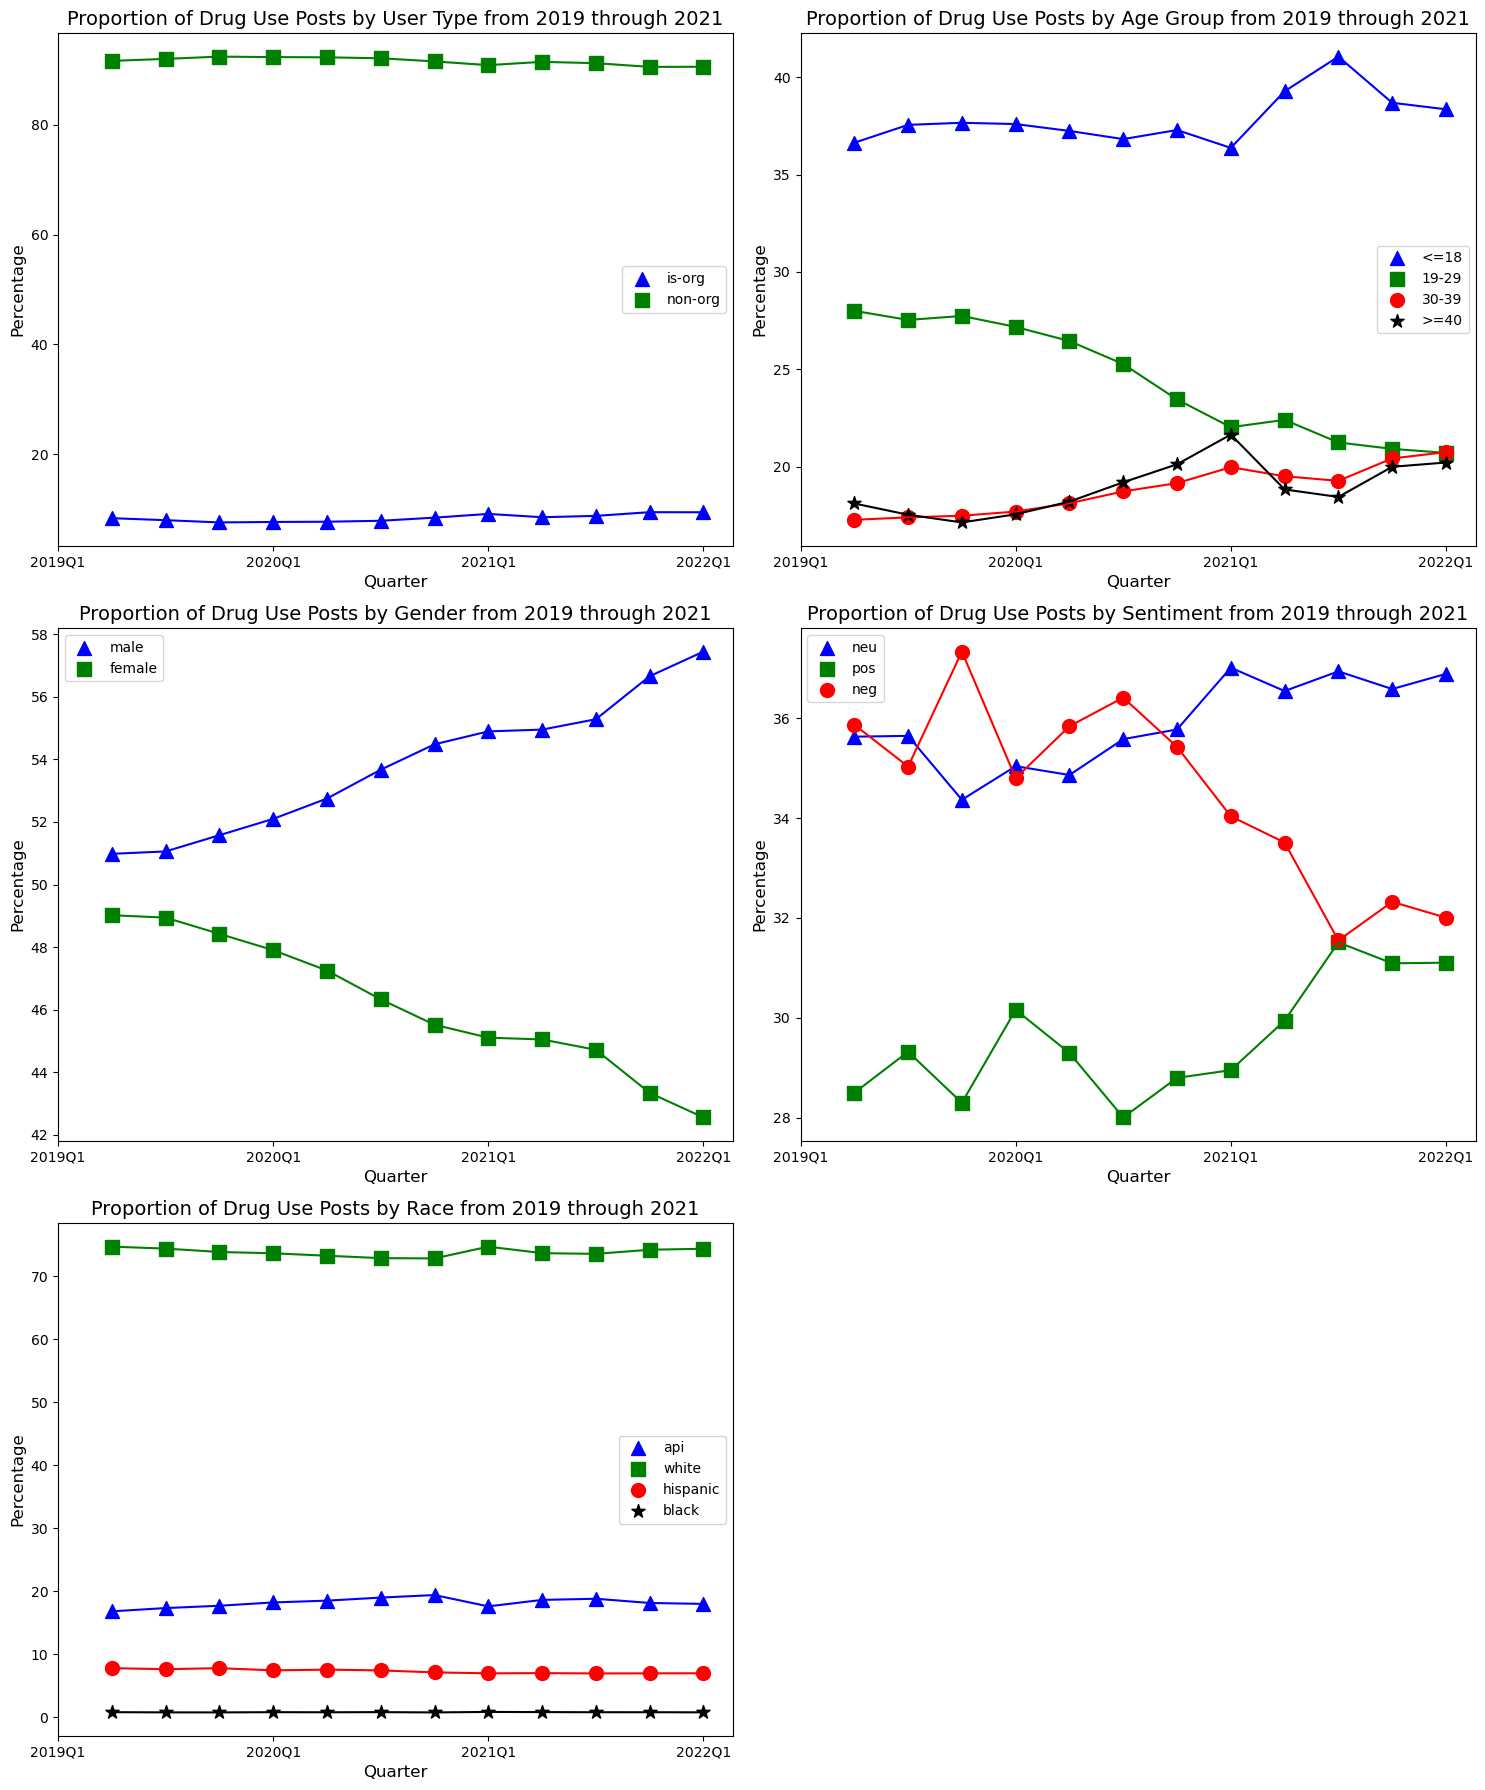

In [156]:
fig, axs = plt.subplots(3, 2, figsize=(15, 18))  # Adjust the grid size (3x2) and figure size as needed
axs = axs.flatten()

# List of parameters for each plot
params = [
    (user_types, user_g, 'User Type', None),
    (age_groups, age_g, 'Age Group', None),
    (gender_types, gender_g, 'Gender', None),
    (sentiment_types, sentiment_g, 'Sentiment', None),
    (race_groups, race_g, 'Race', None)
]

# Plot each trend on a different subplot
for i, (groups, grouped_df, category, drug_type) in enumerate(params):
    plot_trend(groups, grouped_df, 'quarter', category, axs[i], drug_type)

# Remove any empty subplots if there are fewer plots than subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Save the combined image
plt.savefig('combined_plots.png', bbox_inches='tight')

# Show the combined plot
plt.show()


## 4. Trend in drug types

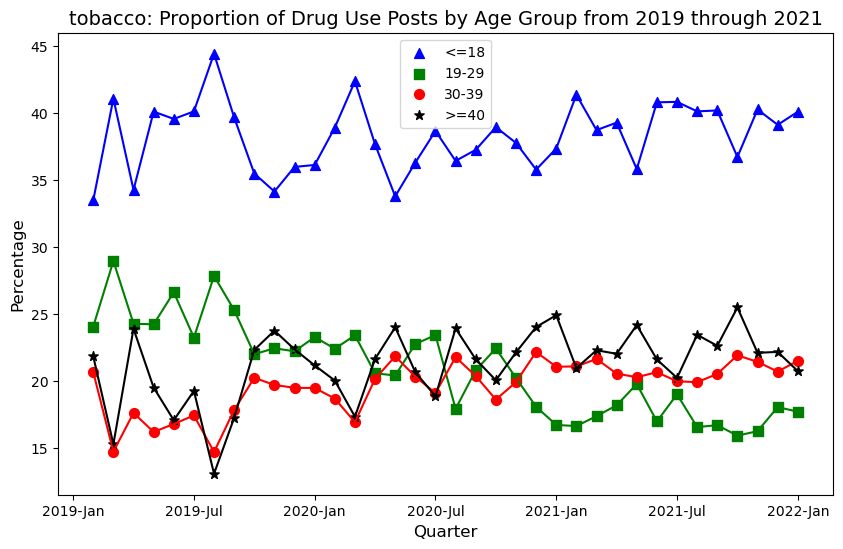

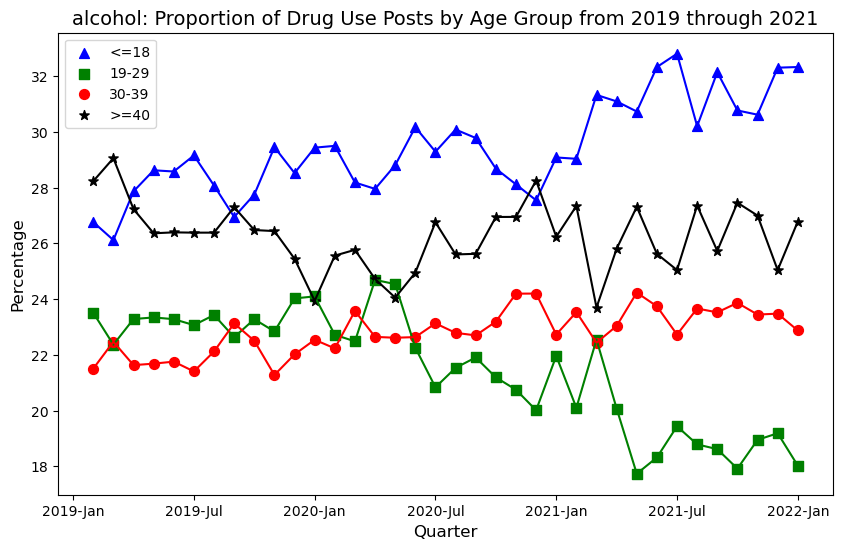

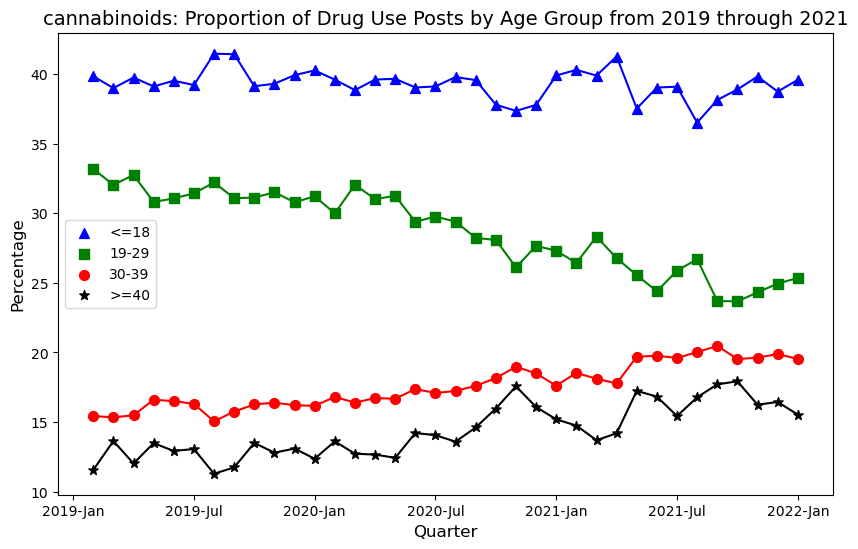

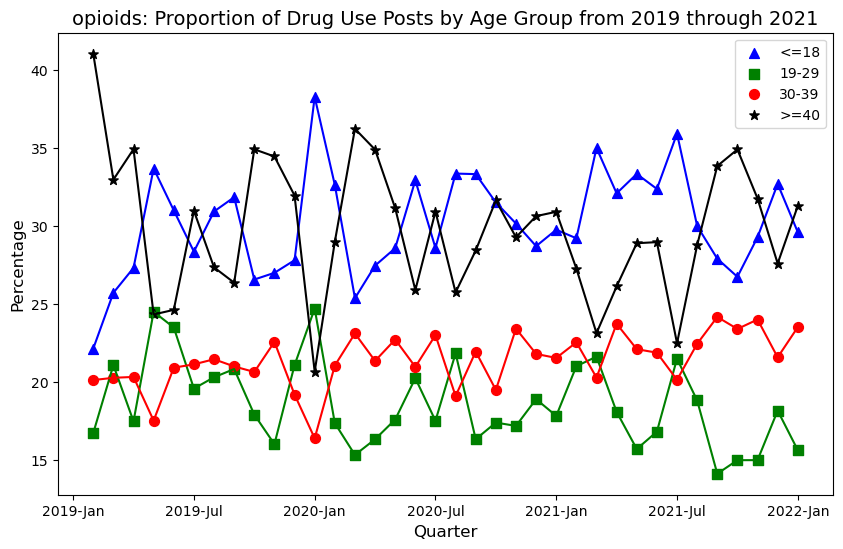

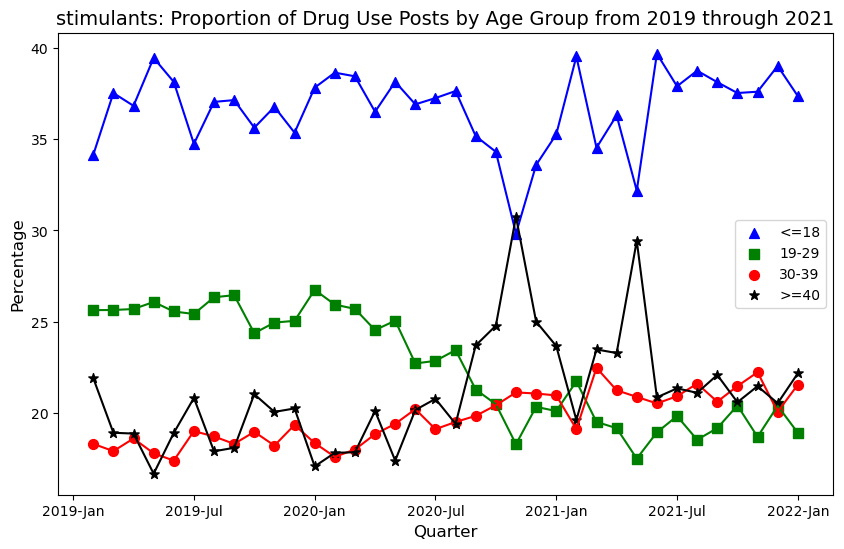

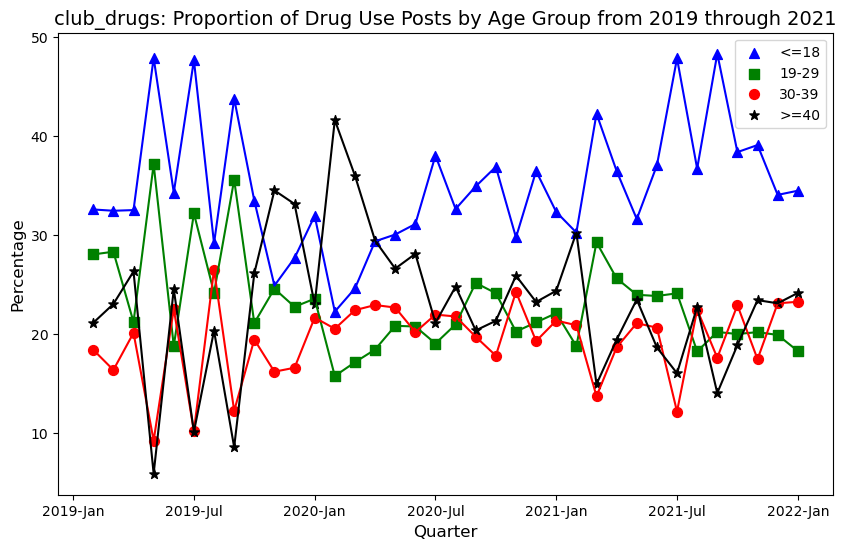

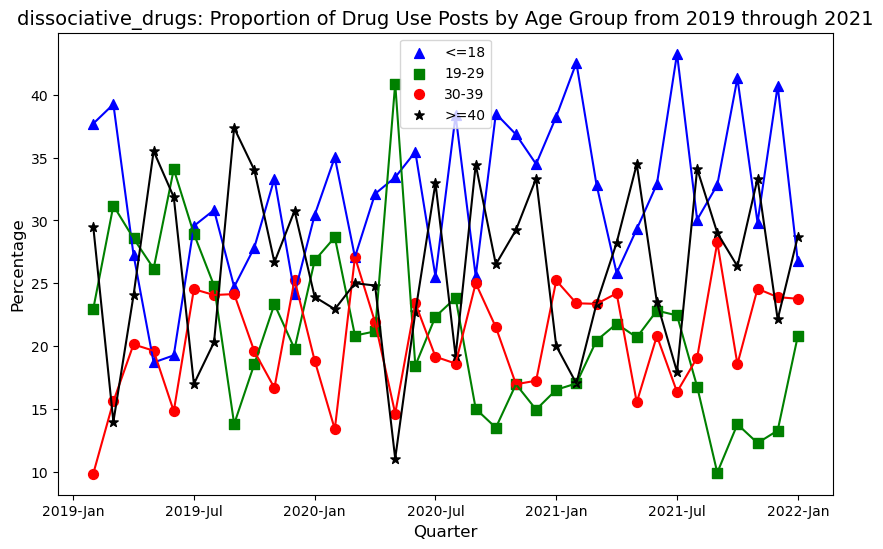

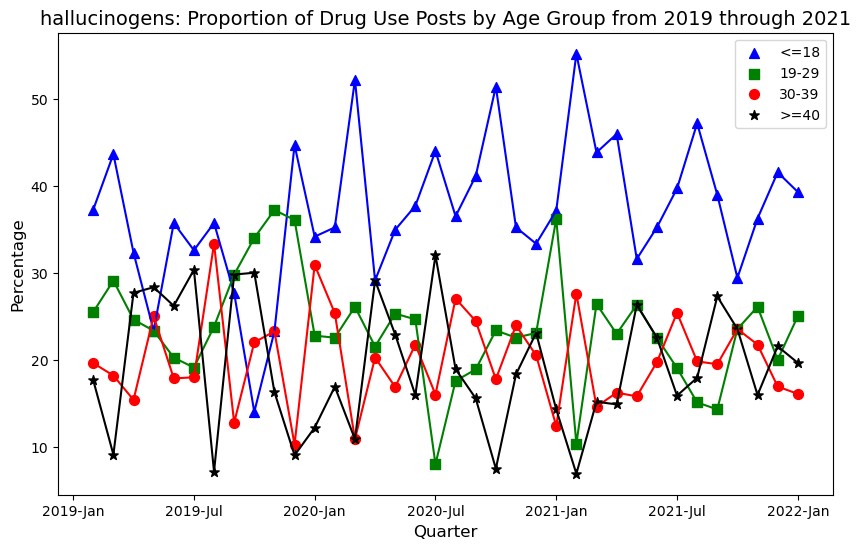

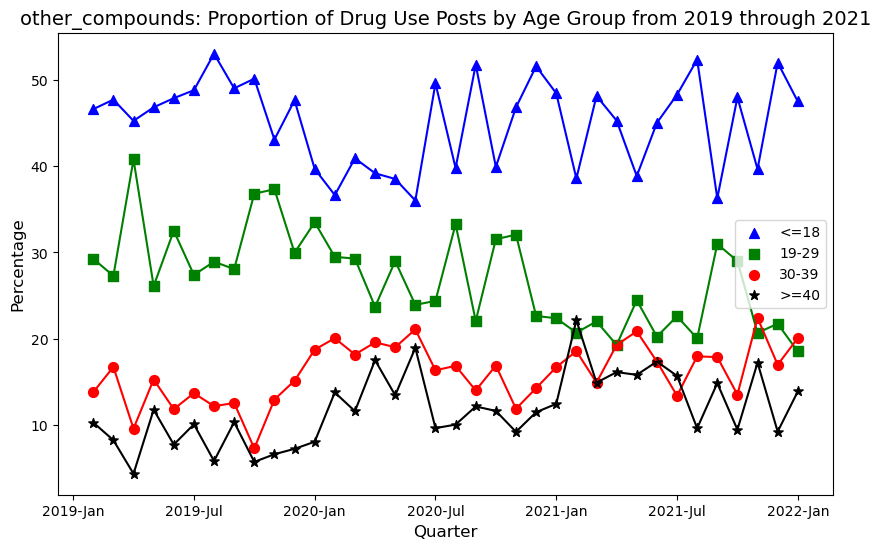

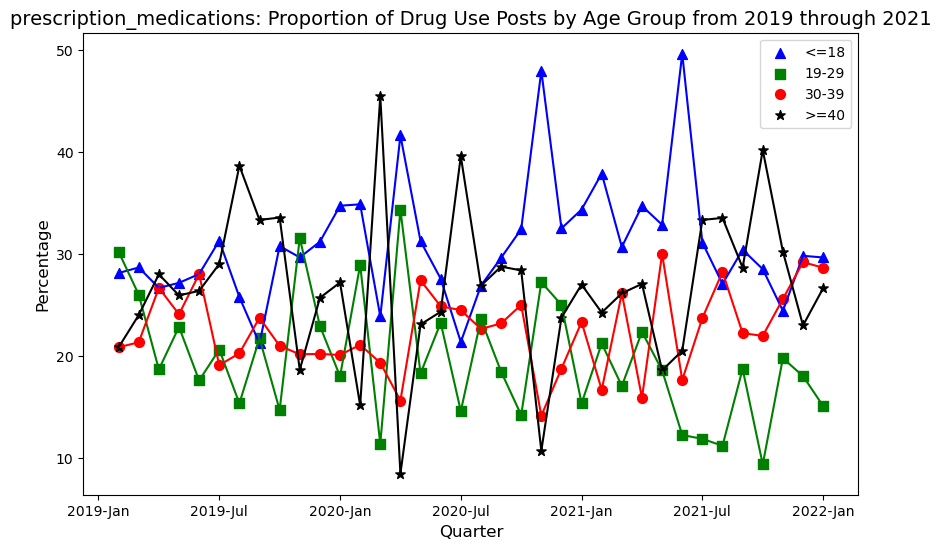

In [142]:
for drug in drug_cols:
    d = data[data['drug_type']==drug] 
    period = 'month'
    user_g = calculate_percentages(d[[period, 'org']], period, 'org', user_types)
    age_g = calculate_percentages(d[[period, 'age']], period, 'age', age_groups)
    gender_g = calculate_percentages(d[[period, 'gender']], period, 'gender', gender_types)
    sentiment_g = calculate_percentages(d[[period, 'sentiment']], period, 'sentiment', sentiment_types)
    race_g = calculate_percentages(d[[period, 'race']], period, 'race', race_groups)
    
    # plot_trend(user_types, user_g, period, 'User Type', '1.proportion_by_user_type.png')
    plot_trend(age_groups, age_g, period, 'Age Group', '2_'+drug+'_proportion_by_age_group.png', drug)
    # plot_trend(gender_types, gender_g, period, 'Gender', '3.proportion_by_gender_group.png')
    # plot_trend(sentiment_types, sentiment_g, period, 'Sentiment', '4.proportion_by_sentiment.png')
    # plot_trend(race_groups, race_g, period, 'Race', '5.proportion_by_race.png')
    


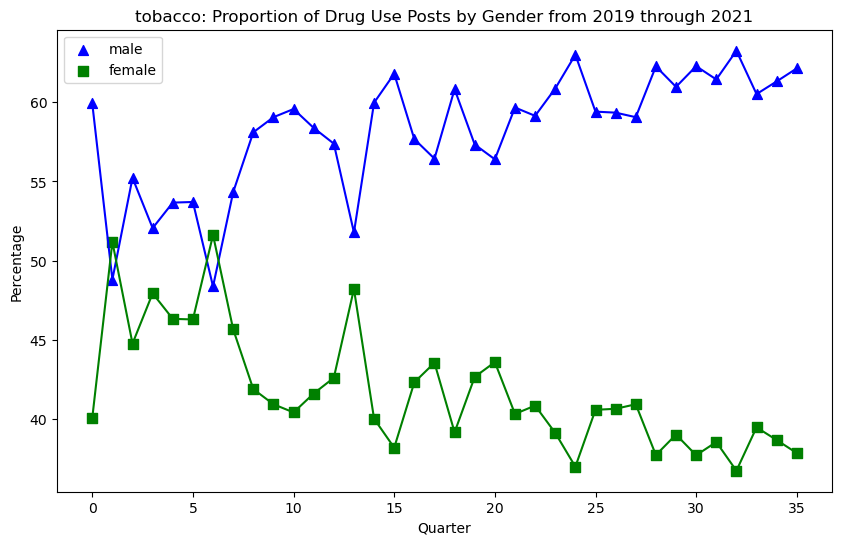

<Figure size 640x480 with 0 Axes>

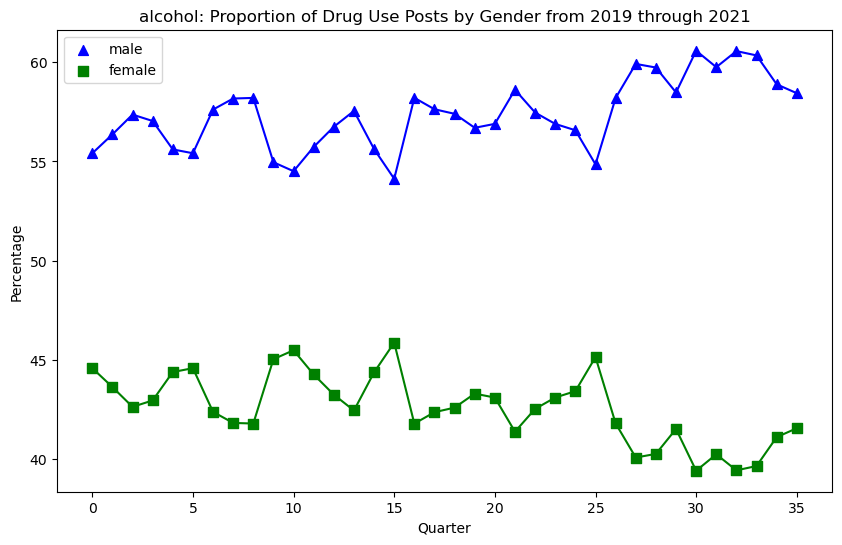

<Figure size 640x480 with 0 Axes>

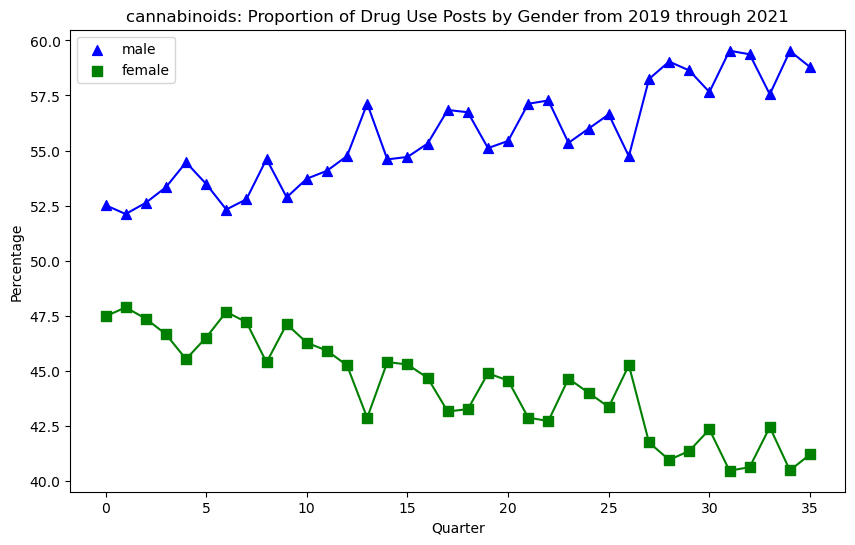

<Figure size 640x480 with 0 Axes>

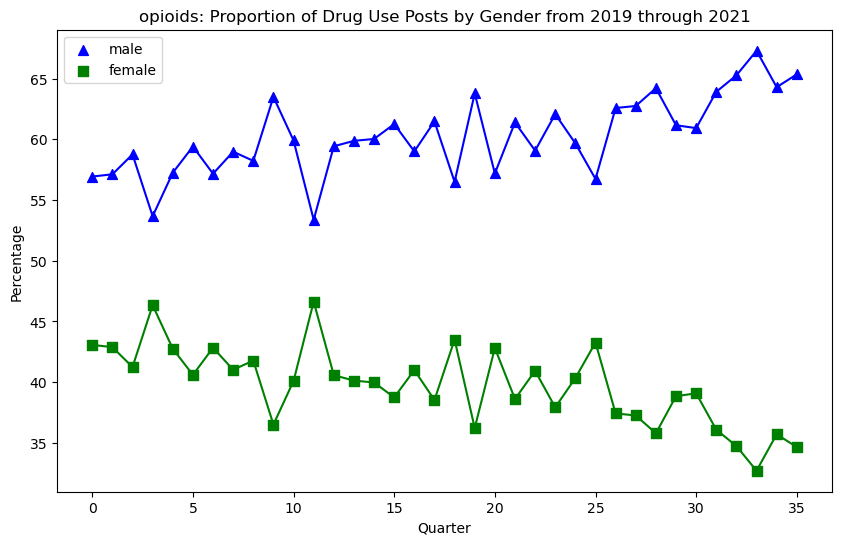

<Figure size 640x480 with 0 Axes>

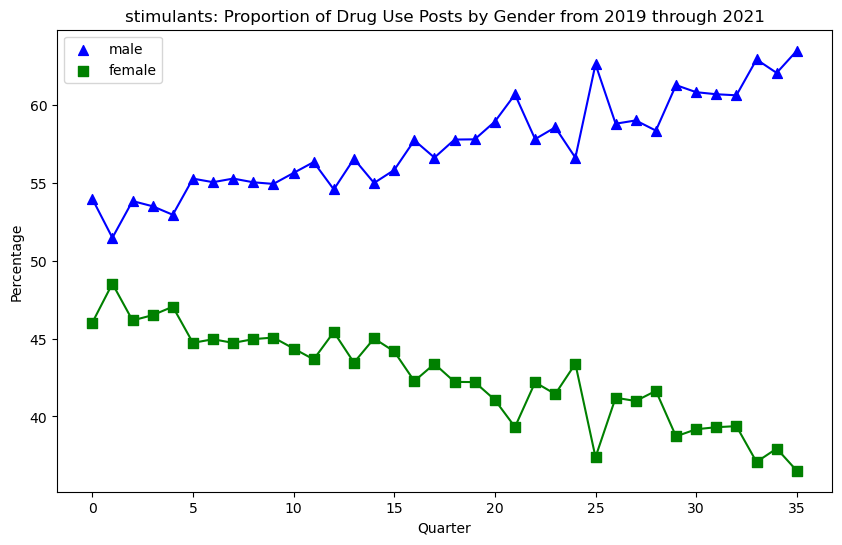

<Figure size 640x480 with 0 Axes>

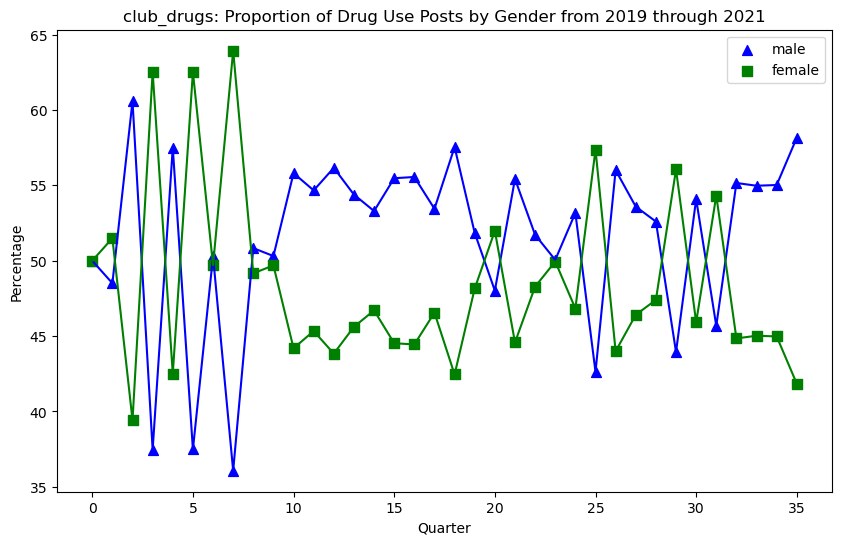

<Figure size 640x480 with 0 Axes>

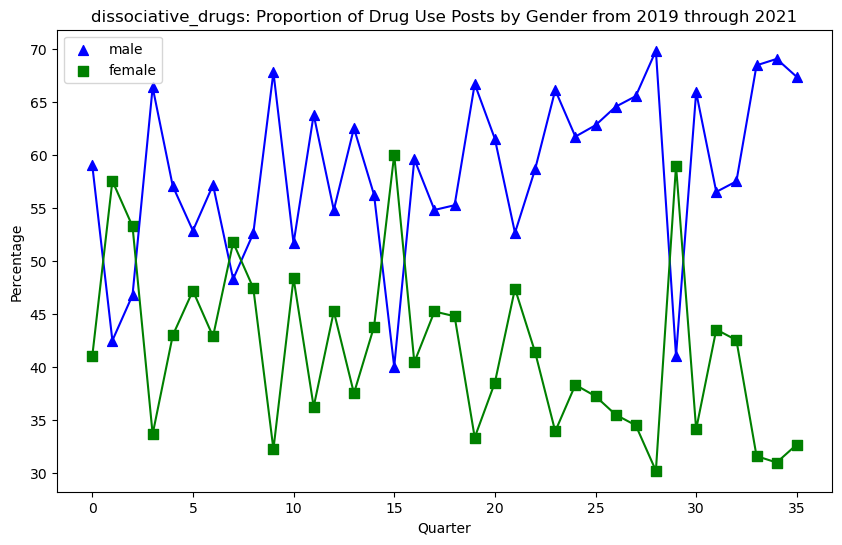

<Figure size 640x480 with 0 Axes>

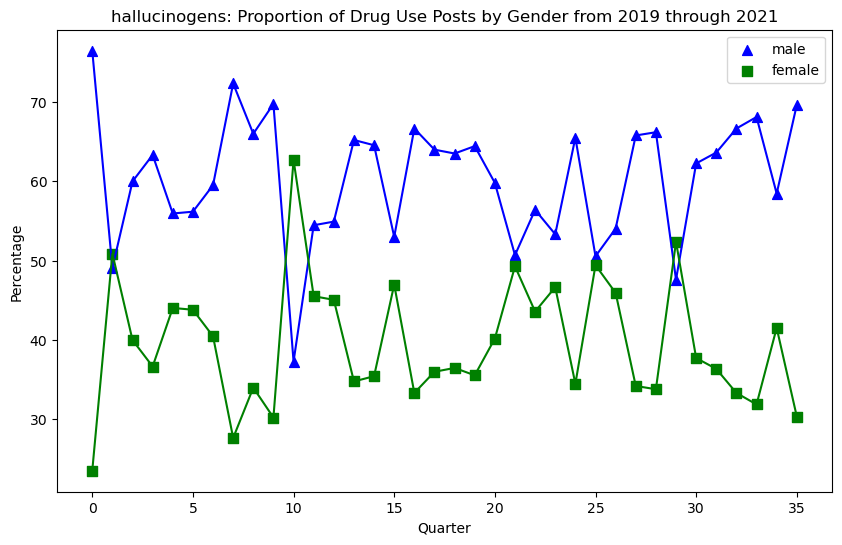

<Figure size 640x480 with 0 Axes>

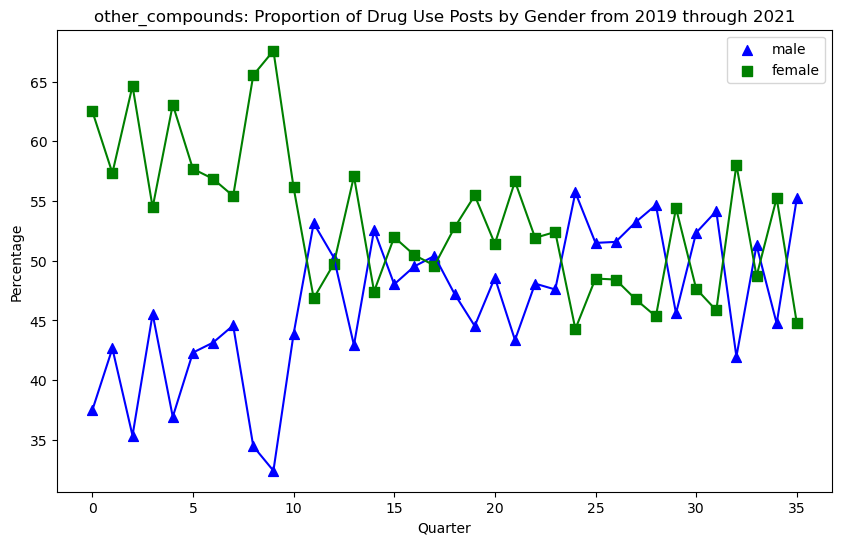

<Figure size 640x480 with 0 Axes>

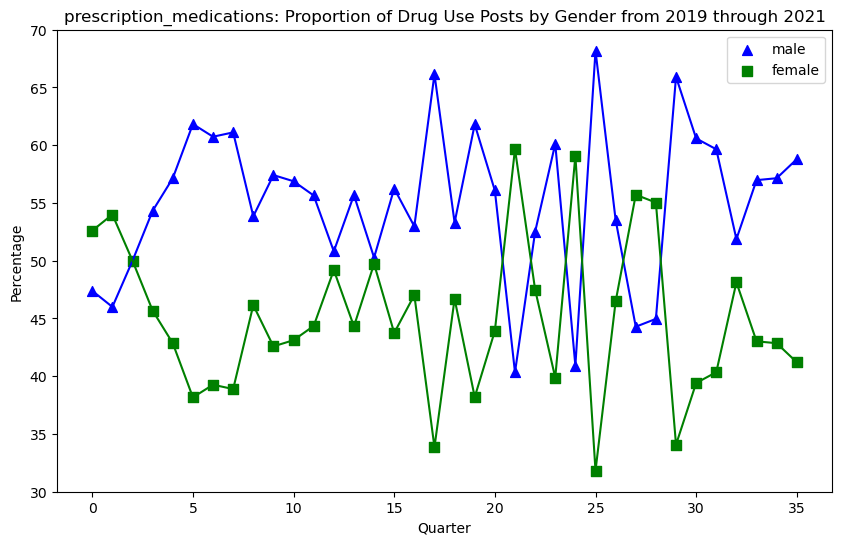

<Figure size 640x480 with 0 Axes>

In [83]:
for drug in drug_cols:
    d = data[data['drug_type']==drug] 
    period = 'month'
    user_g = calculate_percentages(d[[period, 'org']], period, 'org', user_types)
    age_g = calculate_percentages(d[[period, 'age']], period, 'age', age_groups)
    gender_g = calculate_percentages(d[[period, 'gender']], period, 'gender', gender_types)
    sentiment_g = calculate_percentages(d[[period, 'sentiment']], period, 'sentiment', sentiment_types)
    race_g = calculate_percentages(d[[period, 'race']], period, 'race', race_groups)
    
    # plot_trend(user_types, user_g, period, 'User Type', '1.proportion_by_user_type.png')
    # plot_trend(age_groups, age_g, period, 'Age Group', '2._proportion_by_age_group.png', drug)
    plot_trend(gender_types, gender_g, period, 'Gender', '3._proportion_by_gender_group.png', drug)
    # plot_trend(sentiment_types, sentiment_g, period, 'Sentiment', '4.proportion_by_sentiment.png')
    # plot_trend(race_groups, race_g, period, 'Race', '5.proportion_by_race.png')

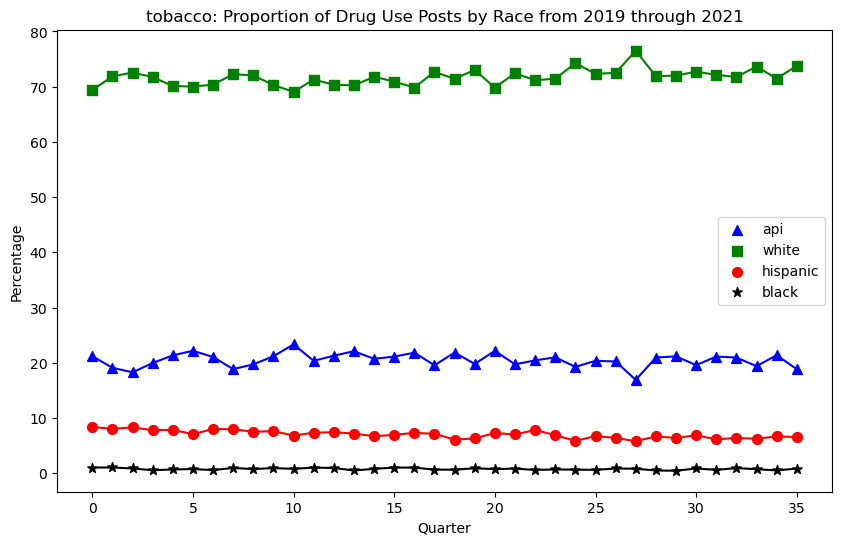

<Figure size 640x480 with 0 Axes>

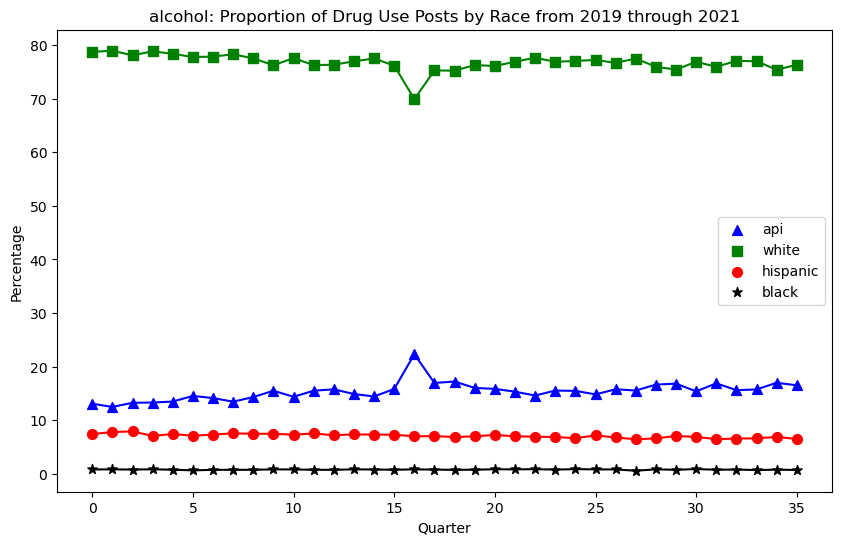

<Figure size 640x480 with 0 Axes>

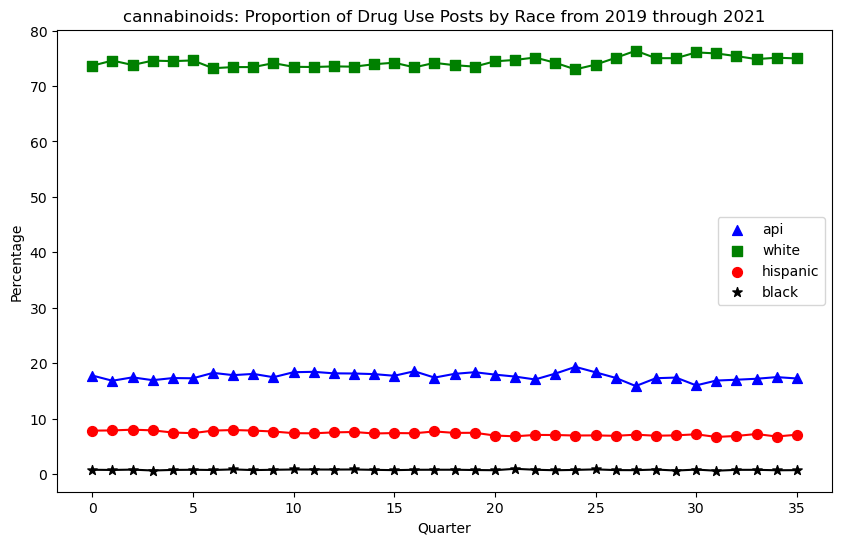

<Figure size 640x480 with 0 Axes>

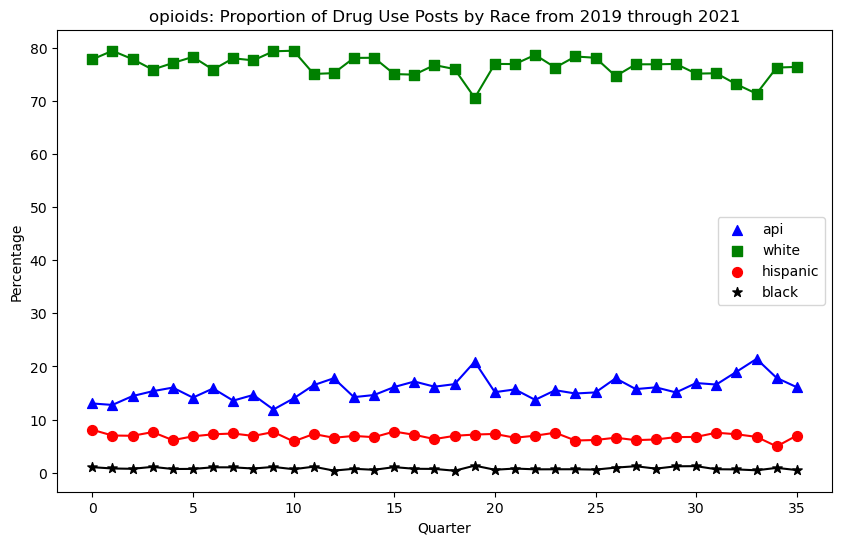

<Figure size 640x480 with 0 Axes>

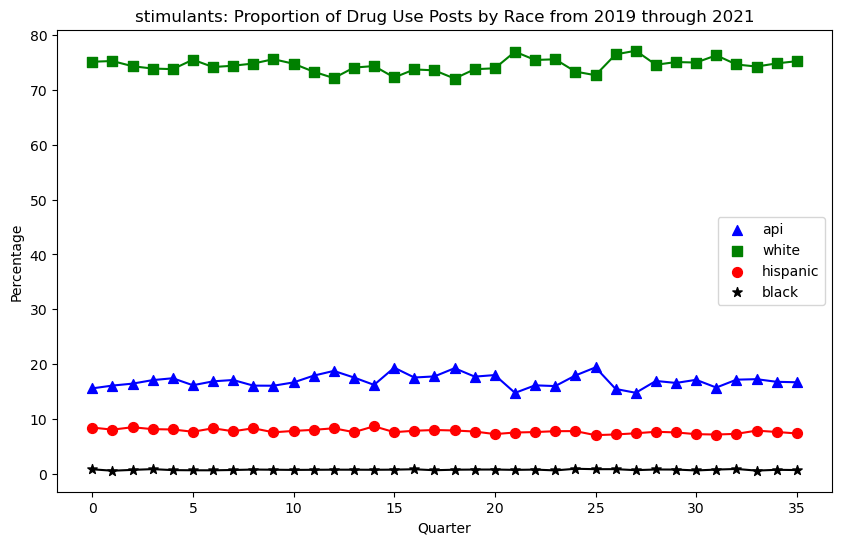

<Figure size 640x480 with 0 Axes>

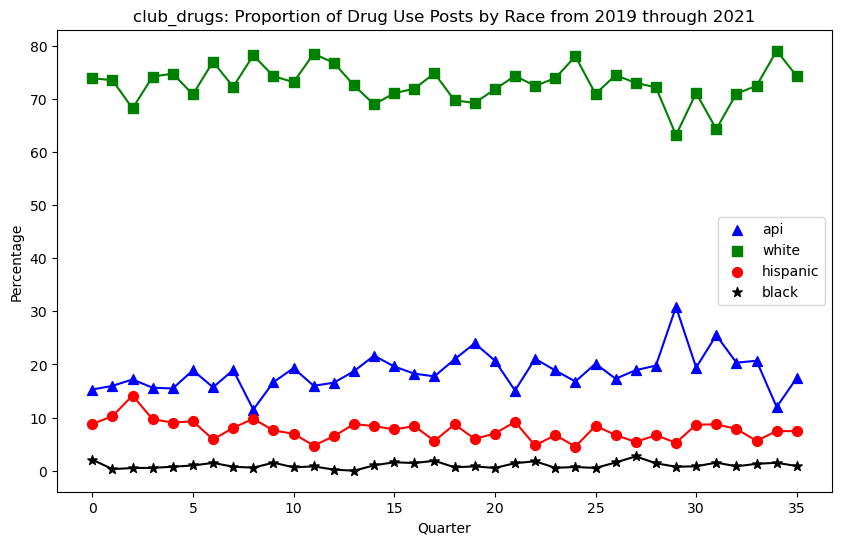

<Figure size 640x480 with 0 Axes>

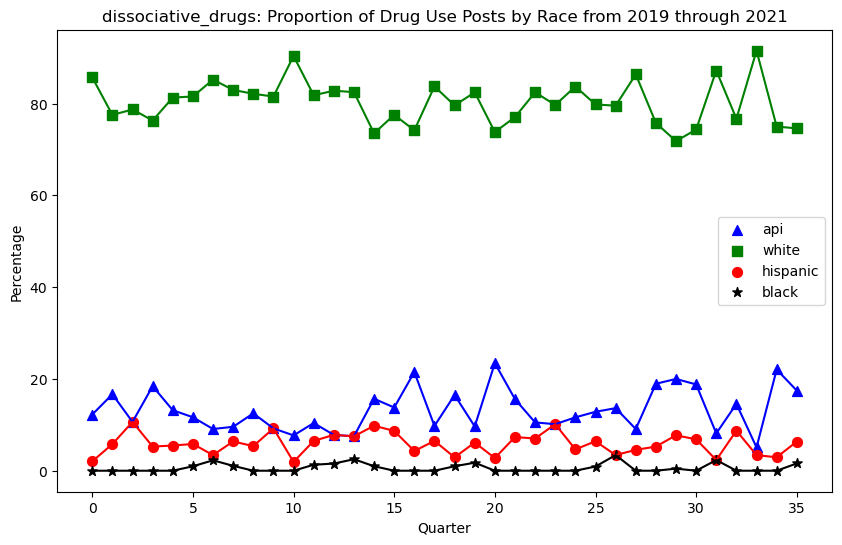

<Figure size 640x480 with 0 Axes>

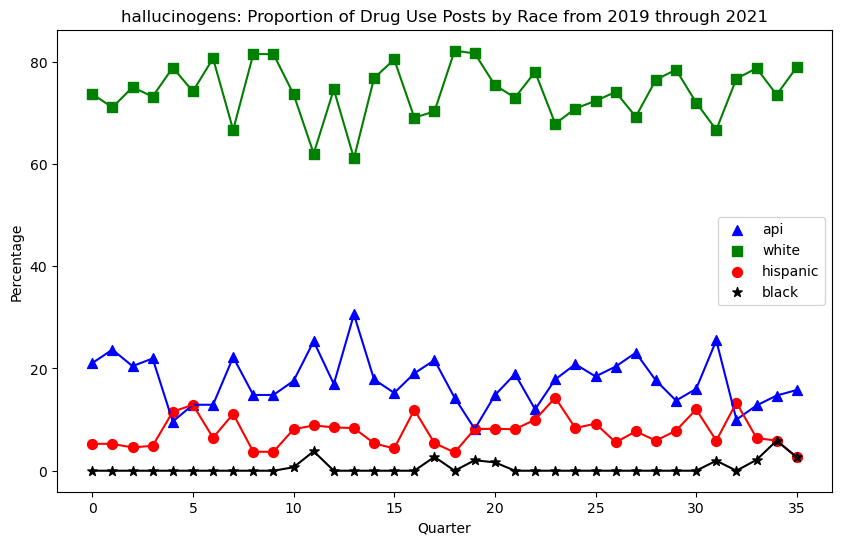

<Figure size 640x480 with 0 Axes>

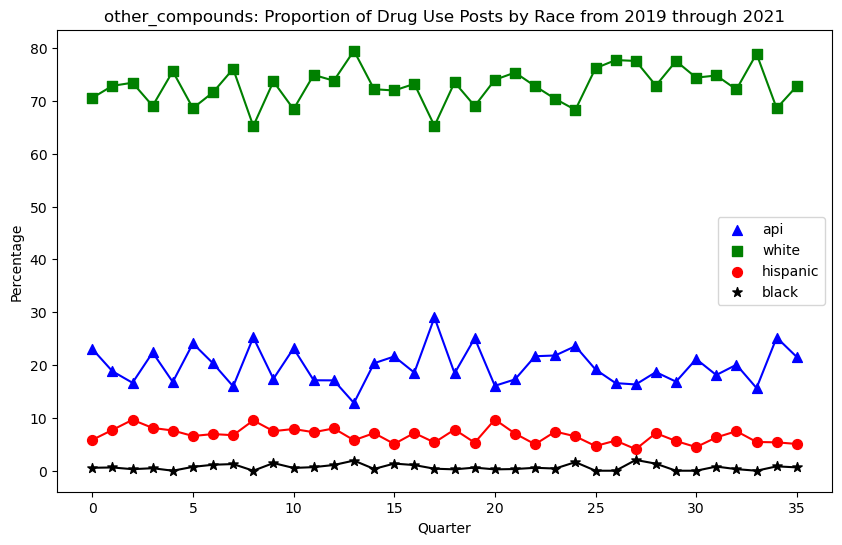

<Figure size 640x480 with 0 Axes>

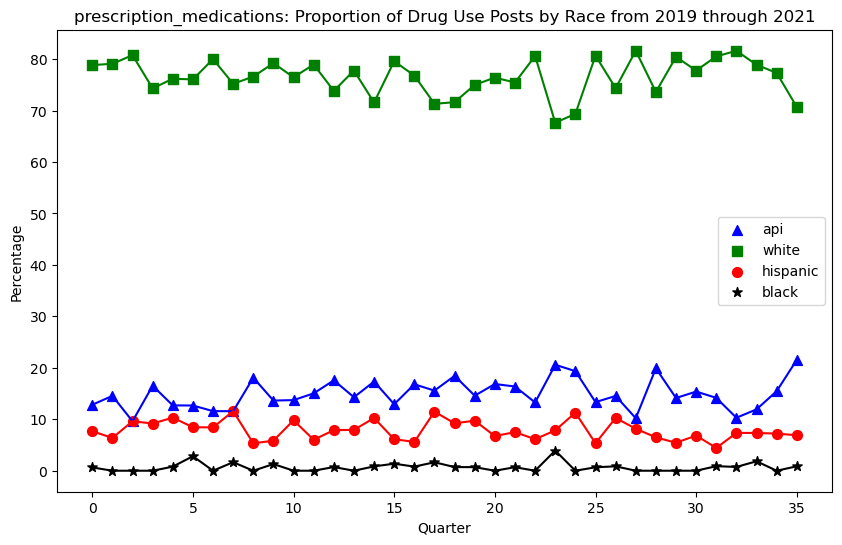

<Figure size 640x480 with 0 Axes>

In [85]:
for drug in drug_cols:
    d = data[data['drug_type']==drug] 
    period = 'month'
    user_g = calculate_percentages(d[[period, 'org']], period, 'org', user_types)
    age_g = calculate_percentages(d[[period, 'age']], period, 'age', age_groups)
    gender_g = calculate_percentages(d[[period, 'gender']], period, 'gender', gender_types)
    sentiment_g = calculate_percentages(d[[period, 'sentiment']], period, 'sentiment', sentiment_types)
    race_g = calculate_percentages(d[[period, 'race']], period, 'race', race_groups)
    
    # plot_trend(user_types, user_g, period, 'User Type', '1.proportion_by_user_type.png')
    # plot_trend(age_groups, age_g, period, 'Age Group', '2._proportion_by_age_group.png', drug)
    # plot_trend(gender_types, gender_g, period, 'Gender', '3._proportion_by_gender_group.png', drug)
    # plot_trend(sentiment_types, sentiment_g, period, 'Sentiment', '4.proportion_by_sentiment.png')
    plot_trend(race_groups, race_g, period, 'Race', '5._proportion_by_race.png', drug)

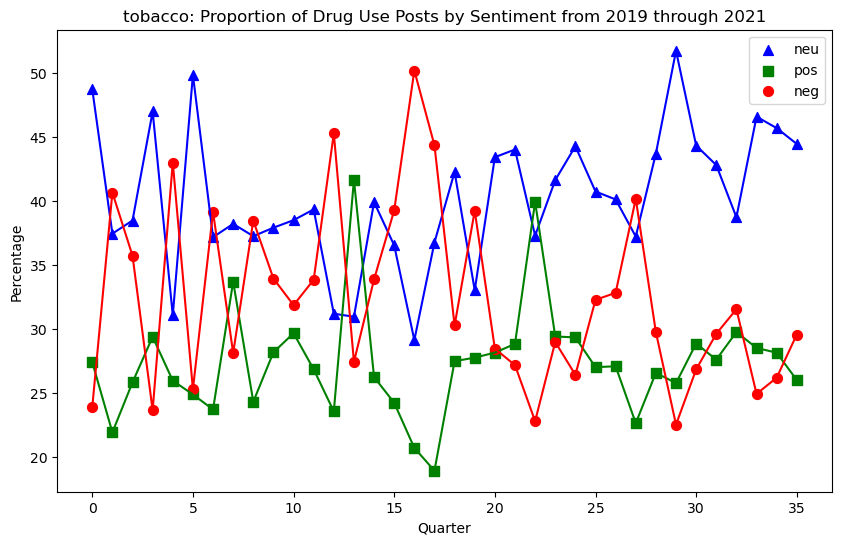

<Figure size 640x480 with 0 Axes>

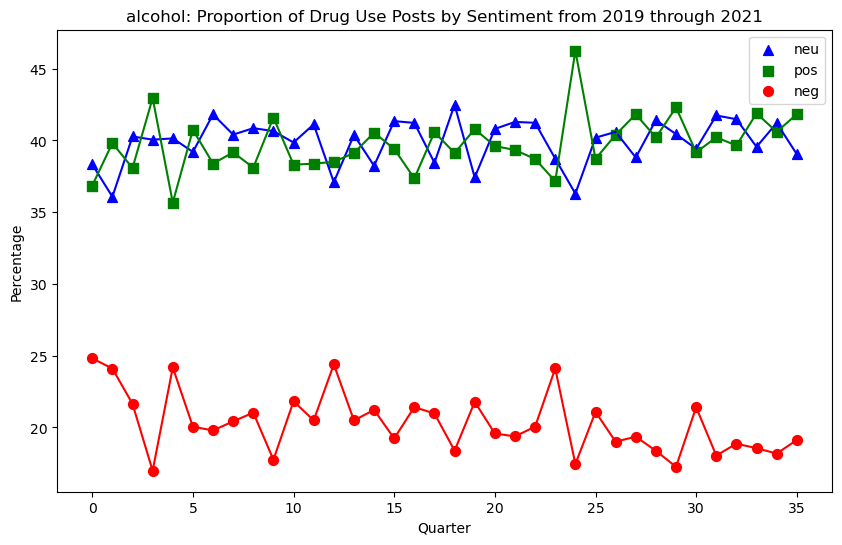

<Figure size 640x480 with 0 Axes>

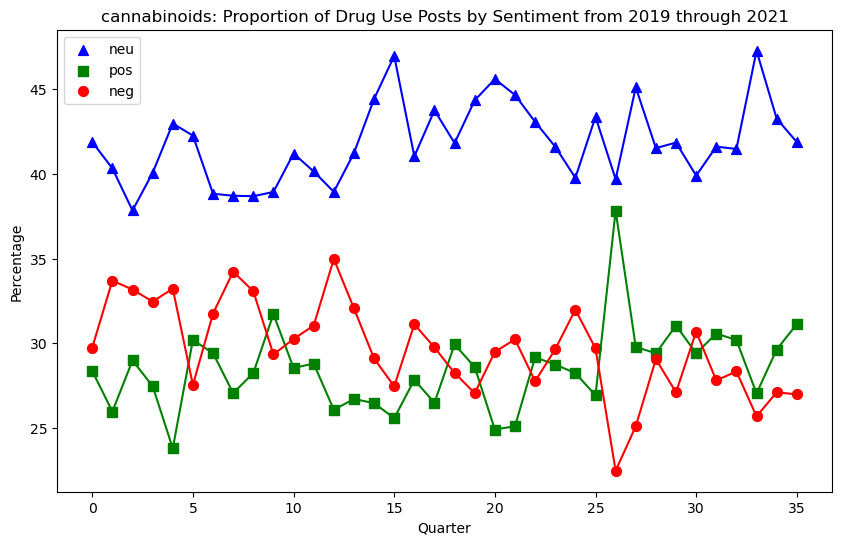

<Figure size 640x480 with 0 Axes>

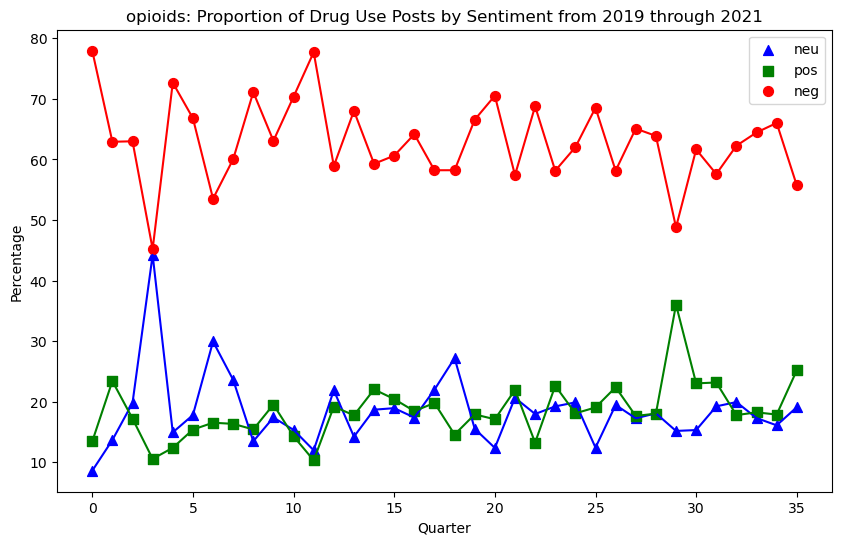

<Figure size 640x480 with 0 Axes>

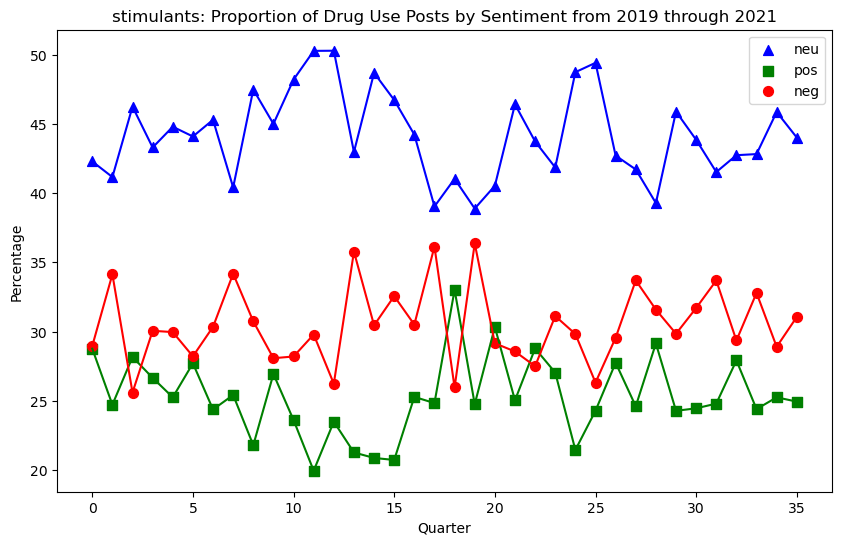

<Figure size 640x480 with 0 Axes>

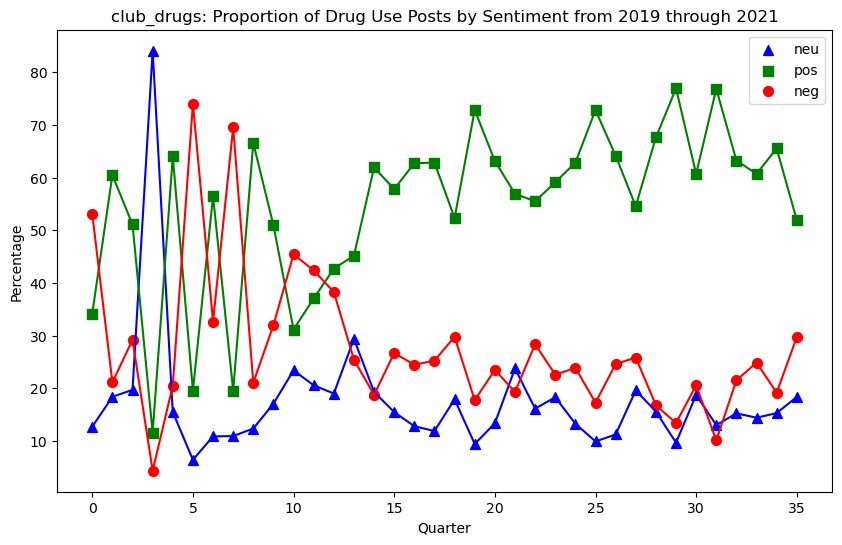

<Figure size 640x480 with 0 Axes>

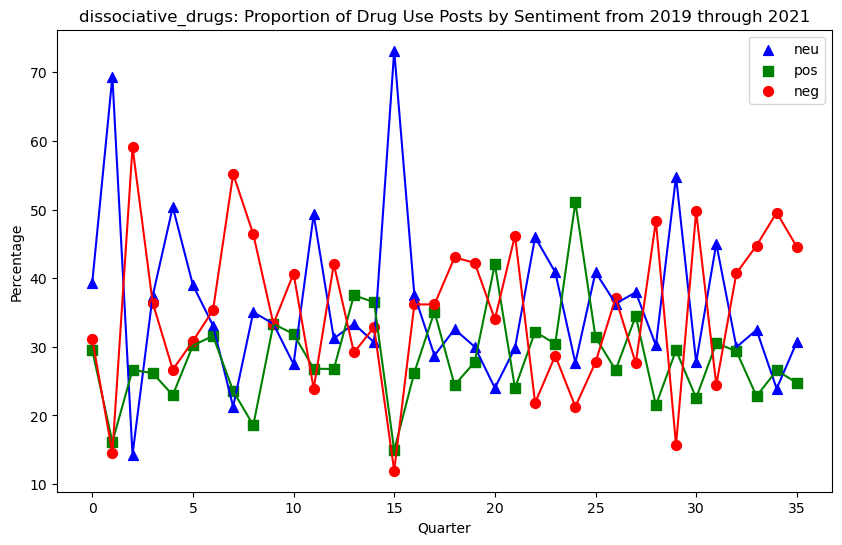

<Figure size 640x480 with 0 Axes>

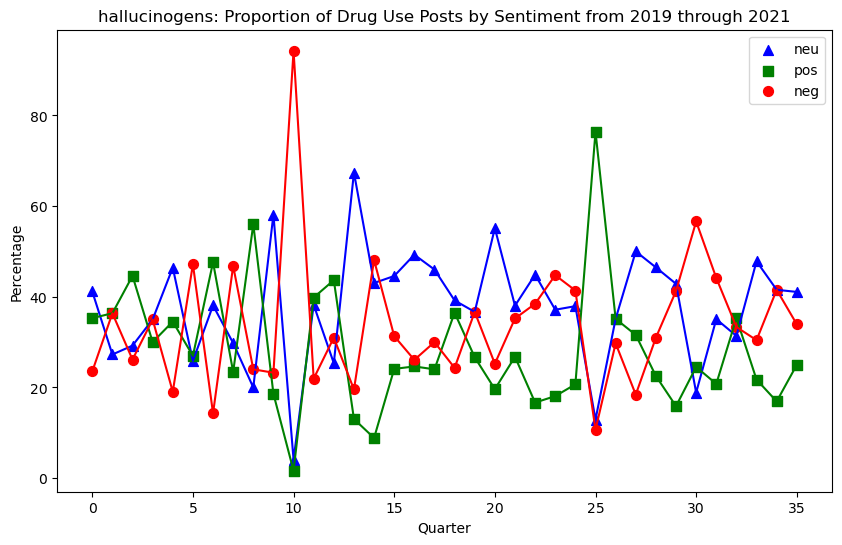

<Figure size 640x480 with 0 Axes>

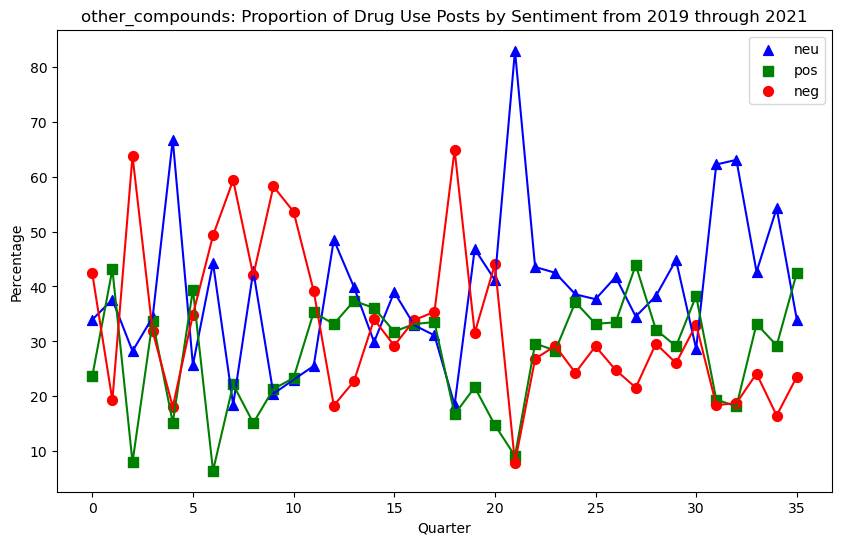

<Figure size 640x480 with 0 Axes>

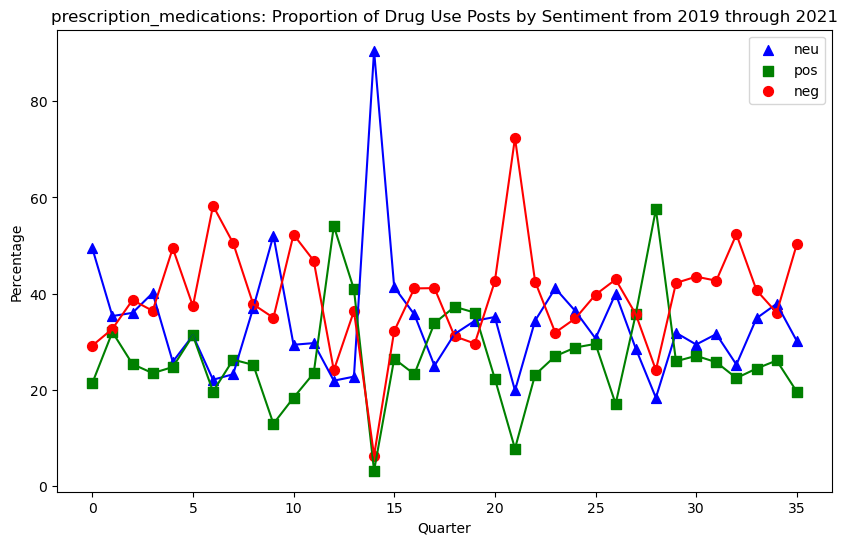

<Figure size 640x480 with 0 Axes>

In [86]:
for drug in drug_cols:
    d = data[data['drug_type']==drug] 
    period = 'month'
    user_g = calculate_percentages(d[[period, 'org']], period, 'org', user_types)
    age_g = calculate_percentages(d[[period, 'age']], period, 'age', age_groups)
    gender_g = calculate_percentages(d[[period, 'gender']], period, 'gender', gender_types)
    sentiment_g = calculate_percentages(d[[period, 'sentiment']], period, 'sentiment', sentiment_types)
    race_g = calculate_percentages(d[[period, 'race']], period, 'race', race_groups)
    
    # plot_trend(user_types, user_g, period, 'User Type', '1.proportion_by_user_type.png')
    # plot_trend(age_groups, age_g, period, 'Age Group', '2._proportion_by_age_group.png', drug)
    # plot_trend(gender_types, gender_g, period, 'Gender', '3._proportion_by_gender_group.png', drug)
    plot_trend(sentiment_types, sentiment_g, period, 'Sentiment', '4._proportion_by_sentiment.png', drug)
    # plot_trend(race_groups, race_g, period, 'Race', '5.proportion_by_race.png')

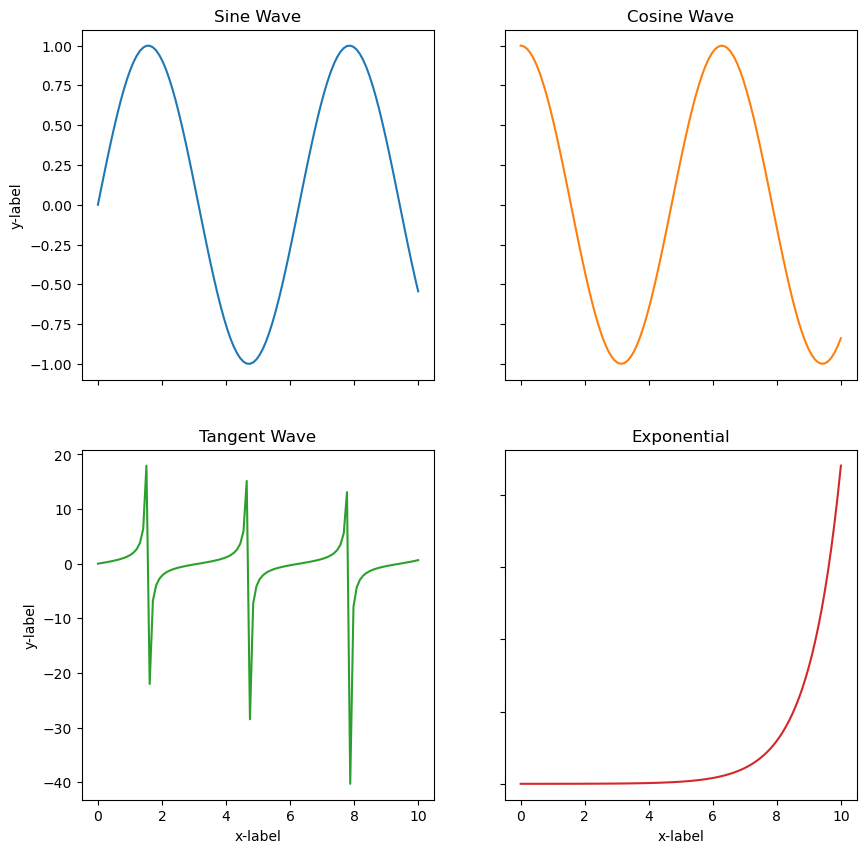

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plots
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot on each subplot
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('Sine Wave')

axs[0, 1].plot(x, y2, 'tab:orange')
axs[0, 1].set_title('Cosine Wave')

axs[1, 0].plot(x, y3, 'tab:green')
axs[1, 0].set_title('Tangent Wave')

axs[1, 1].plot(x, y4, 'tab:red')
axs[1, 1].set_title('Exponential')

# Set labels
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Save the figure as a single PNG file
plt.savefig('grouped_plots.png')

# Show the plot
plt.show()
